## Imports and Helper Functions

In [1]:
import json
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import time

# This function reads the JSON file and converts it into a clean Pandas DataFrame
def load_stats(filepath):
    if not os.path.exists(filepath):
        print(f"File not found: {filepath}")
        return None
        
    with open(filepath, 'r') as f:
        data = json.load(f)
        
    df = pd.DataFrame(data['train_stats'])
    return df

# Reinforcement learning data is very spiky. This applies a moving average so we can see the trend.
def smooth_data(data, window=100):
    return data.rolling(window=window, min_periods=1).mean()

## Running the Hyperparameter Experiments
Here, we execute the `yellow_drift.py` script multiple times using shell commands. We test six distinct hyperparameter configurations over 5,000 episodes each:
* **Baseline:** Alpha = 0.1, Epsilon = 0.1
* **Alpha Variations:** Testing extremely slow learning (0.001) up to aggressive learning (0.2).
* **Epsilon Variations:** Testing higher exploration rates (0.2 and 0.3).

*Note: The script runs in `--no-gui` mode to rapidly generate the statistical data without triggering the visual environment renderer.*

In [2]:
# Create the results folder if it doesn't exist
os.makedirs('results', exist_ok=True)

# Dictionary to store running times
runtimes = {}

print("Running Baseline...")
start_time = time.time()
!python yellow_drift.py --alpha 0.1 --epsilon 0.1 --gamma 0.9 --episodes 5000 --log-every 1000 --export-stats results/baseline.json --no-gui
runtimes['Baseline\n(A=0.1, E=0.1)'] = time.time() - start_time

print("Running Alpha Variations...")
start_time = time.time()
!python yellow_drift.py --alpha 0.01 --epsilon 0.1 --gamma 0.9 --episodes 5000 --log-every 1000 --export-stats results/alpha_0.01.json --no-gui
runtimes['Alpha = 0.01'] = time.time() - start_time

start_time = time.time()
!python yellow_drift.py --alpha 0.001 --epsilon 0.1 --gamma 0.9 --episodes 5000 --log-every 1000 --export-stats results/alpha_0.001.json --no-gui
runtimes['Alpha = 0.001'] = time.time() - start_time

start_time = time.time()
!python yellow_drift.py --alpha 0.2 --epsilon 0.1 --gamma 0.9 --episodes 5000 --log-every 1000 --export-stats results/alpha_0.2.json --no-gui
runtimes['Alpha = 0.2'] = time.time() - start_time

print("Running Epsilon Variations...")
start_time = time.time()
!python yellow_drift.py --alpha 0.1 --epsilon 0.2 --gamma 0.9 --episodes 5000 --log-every 1000 --export-stats results/eps_0.2.json --no-gui
runtimes['Epsilon = 0.2'] = time.time() - start_time

start_time = time.time()
!python yellow_drift.py --alpha 0.1 --epsilon 0.3 --gamma 0.9 --episodes 5000 --log-every 1000 --export-stats results/eps_0.3.json --no-gui
runtimes['Epsilon = 0.3'] = time.time() - start_time

# Save the runtimes so we can plot them in another cell
with open('results/runtimes.json', 'w') as f:
    json.dump(runtimes, f)

print("All training runs completed successfully! Runtimes saved.")

Running Baseline...

--- Environment Description (from assignment2_utils) ---
Observation space:  Discrete(500)
Observation space size:  500
Reward Range:  (-inf, inf)
Number of actions:  6
Action description:  {0: 'Move south (down)', 1: 'Move north (up)', 2: 'Move east (right)', 3: 'Move west (left)', 4: 'Pickup passenger', 5: 'Drop off passenger'}
--------------------------------------------------------

[episode   1000] avg_reward=-110.899 avg_len=88.3 success_rate=82.40% eps=0.100
[episode   2000] avg_reward=-1.988 avg_len=17.9 success_rate=100.00% eps=0.100
[episode   3000] avg_reward=+1.587 avg_len=15.0 success_rate=100.00% eps=0.100
[episode   4000] avg_reward=+2.307 avg_len=14.7 success_rate=100.00% eps=0.100
[episode   5000] avg_reward=+2.130 avg_len=14.7 success_rate=100.00% eps=0.100

Evaluation (greedy): {'episodes': 200.0, 'avg_reward': 8.25, 'std_reward': 2.3848, 'avg_length': 12.75, 'success_rate': 1.0}
Running Alpha Variations...

--- Environment Description (from assi

## Loading the Results
With the simulations complete, we load the exported JSON datasets into memory. 
Each DataFrame now contains the episode number, steps taken, total reward, and epsilon value for every step of the training process.

In [3]:
# Load all generated JSON files
baseline = load_stats('results/baseline.json')

# Alpha variations
alpha_01 = load_stats('results/alpha_0.01.json')
alpha_001 = load_stats('results/alpha_0.001.json')
alpha_2 = load_stats('results/alpha_0.2.json')

# Epsilon variations
eps_2 = load_stats('results/eps_0.2.json')
eps_3 = load_stats('results/eps_0.3.json')

print("All data loaded successfully!")

All data loaded successfully!


## Impact of the Learning Rate (Alpha) on Efficiency
This plot visualizes how the Learning Rate (Alpha) affects the agent's ability to find the shortest path to the goal. 
We measure this by tracking the number of steps it takes to terminate an episode. 
A steeper drop indicates that the agent is quickly learning to avoid wandering and is optimizing its route.

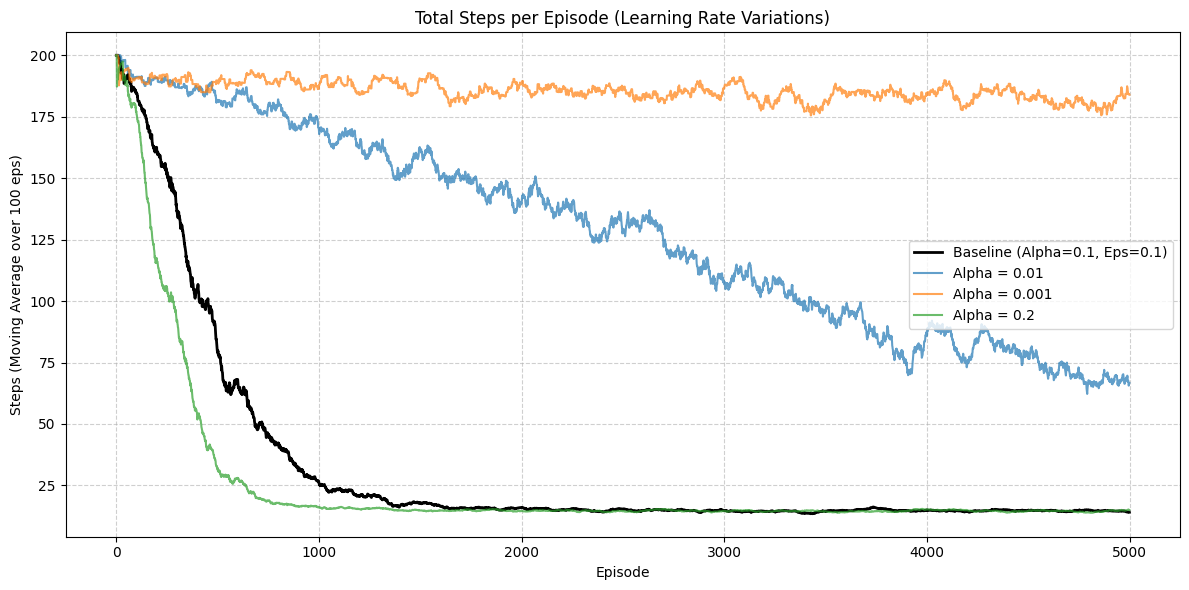

In [4]:
plt.figure(figsize=(12, 6))

# Define the smoothing window (100 episodes)
window = 100

# Plotting the baseline and the Alpha variations
plt.plot(baseline['episode'], smooth_data(baseline['steps'], window), label='Baseline (Alpha=0.1, Eps=0.1)', color='black', linewidth=2)
plt.plot(alpha_01['episode'], smooth_data(alpha_01['steps'], window), label='Alpha = 0.01', alpha=0.7)
plt.plot(alpha_001['episode'], smooth_data(alpha_001['steps'], window), label='Alpha = 0.001', alpha=0.7)
plt.plot(alpha_2['episode'], smooth_data(alpha_2['steps'], window), label='Alpha = 0.2', alpha=0.7)

plt.title('Total Steps per Episode (Learning Rate Variations)')
plt.xlabel('Episode')
plt.ylabel(f'Steps (Moving Average over {window} eps)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()

## Impact of Exploration (Epsilon) on Average Returns
This chart isolates the Exploration Rate (Epsilon) and tracks the Moving Average Reward. 
Because high exploration means the agent intentionally takes random actions, we expect configurations with higher Epsilon values to have lower average returns, even if they theoretically prevent the agent from getting stuck in local optima.

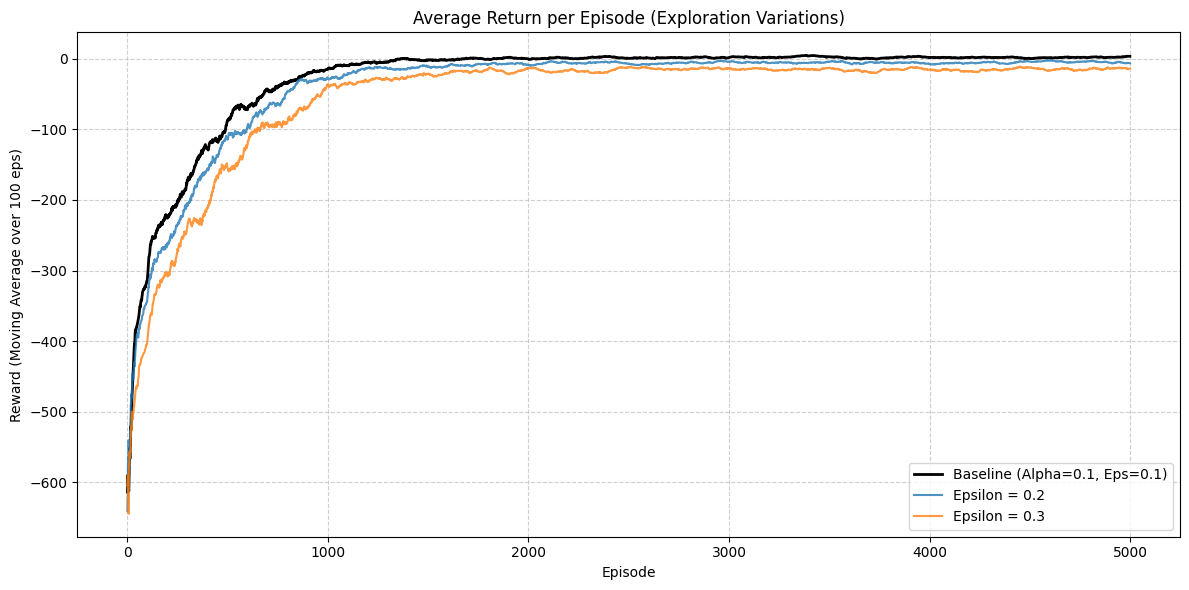

In [5]:
plt.figure(figsize=(12, 6))

# Plotting the baseline and the Epsilon variations
plt.plot(baseline['episode'], smooth_data(baseline['total_reward'], window), label='Baseline (Alpha=0.1, Eps=0.1)', color='black', linewidth=2)
plt.plot(eps_2['episode'], smooth_data(eps_2['total_reward'], window), label='Epsilon = 0.2', alpha=0.8)
plt.plot(eps_3['episode'], smooth_data(eps_3['total_reward'], window), label='Epsilon = 0.3', alpha=0.8)

plt.title('Average Return per Episode (Exploration Variations)')
plt.xlabel('Episode')
plt.ylabel(f'Reward (Moving Average over {window} eps)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()

## Computational Cost (Running Time)
Finally, we evaluate the computational cost of these hyperparameter choices. 
This bar chart shows the total wall-clock time required to simulate 5,000 episodes under each configuration. 
This gives a good idea of how long it will take the agent to reach the target state

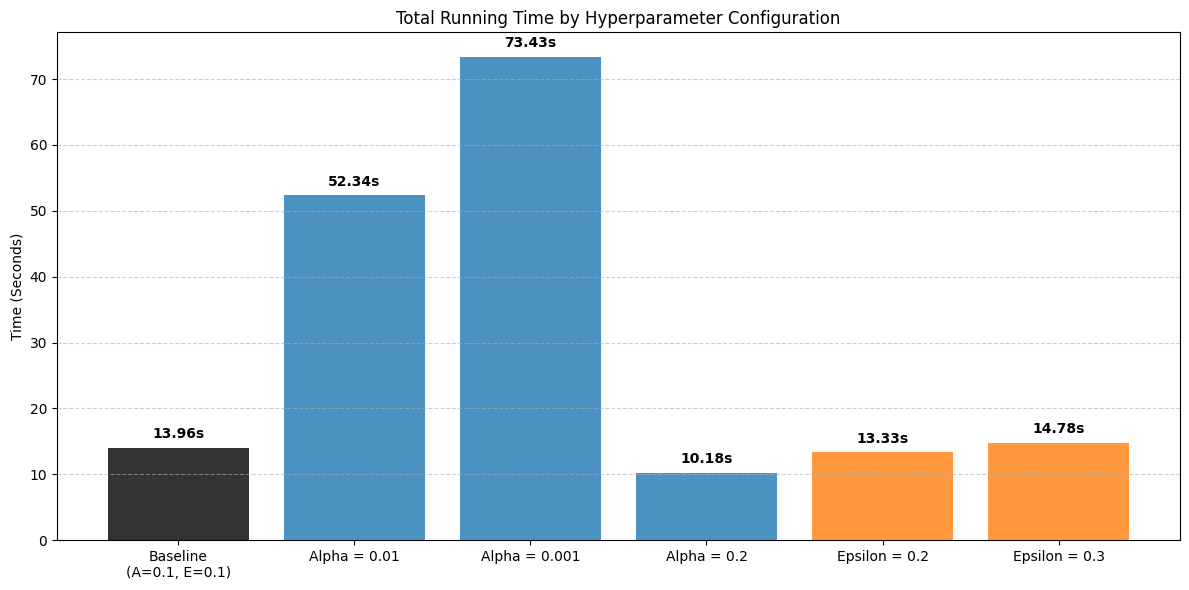

In [6]:
plt.figure(figsize=(12, 6))

# Load the saved runtimes
with open('results/runtimes.json', 'r') as f:
    runtimes = json.load(f)

labels = list(runtimes.keys())
times = list(runtimes.values())

# Color-coding: Baseline (black), Alpha variations (blue), Epsilon variations (orange)
colors = ['black', '#1f77b4', '#1f77b4', '#1f77b4', '#ff7f0e', '#ff7f0e']

# Create the bar chart
bars = plt.bar(labels, times, color=colors, alpha=0.8)

plt.title('Total Running Time by Hyperparameter Configuration')
plt.ylabel('Time (Seconds)')
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Add the precise time labels on top of each bar for the audience
for bar, time_val in zip(bars, times):
    plt.text(bar.get_x() + bar.get_width()/2, time_val + (max(times)*0.02), 
             f'{time_val:.2f}s', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

## Finding the Optimal Combination (Epsilon Decay)
Based on the previous results, we observed that a higher Learning Rate ($\alpha$) allows the agent to find optimal paths faster, but a fixed Exploration Rate ($\epsilon$) permanently suppresses the maximum average reward because the agent never stops making random moves. 

To solve this, we will test an **Optimal Configuration**: a fast Learning Rate (`Alpha = 0.2`) paired with an **Epsilon Decay** schedule. This means the agent will start with 100% exploration ($\epsilon=1.0$) to rapidly learn the map, and slowly decay to 5% exploration ($\epsilon=0.05$) to safely exploit its knowledge.

Running Optimal Configuration (Alpha=0.2 + Epsilon Decay)...

--- Environment Description (from assignment2_utils) ---
Observation space:  Discrete(500)
Observation space size:  500
Reward Range:  (-inf, inf)
Number of actions:  6
Action description:  {0: 'Move south (down)', 1: 'Move north (up)', 2: 'Move east (right)', 3: 'Move west (left)', 4: 'Pickup passenger', 5: 'Drop off passenger'}
--------------------------------------------------------

[episode   1000] avg_reward=-299.050 avg_len=97.6 success_rate=71.70% eps=0.400
[episode   2000] avg_reward=-13.002 avg_len=19.0 success_rate=100.00% eps=0.179
[episode   3000] avg_reward=-0.103 avg_len=15.4 success_rate=100.00% eps=0.097
[episode   4000] avg_reward=+3.309 avg_len=14.3 success_rate=100.00% eps=0.067
[episode   5000] avg_reward=+4.356 avg_len=14.1 success_rate=100.00% eps=0.056

Evaluation (greedy): {'episodes': 200.0, 'avg_reward': 7.98, 'std_reward': 2.3536, 'avg_length': 13.02, 'success_rate': 1.0}
Optimal run completed in 

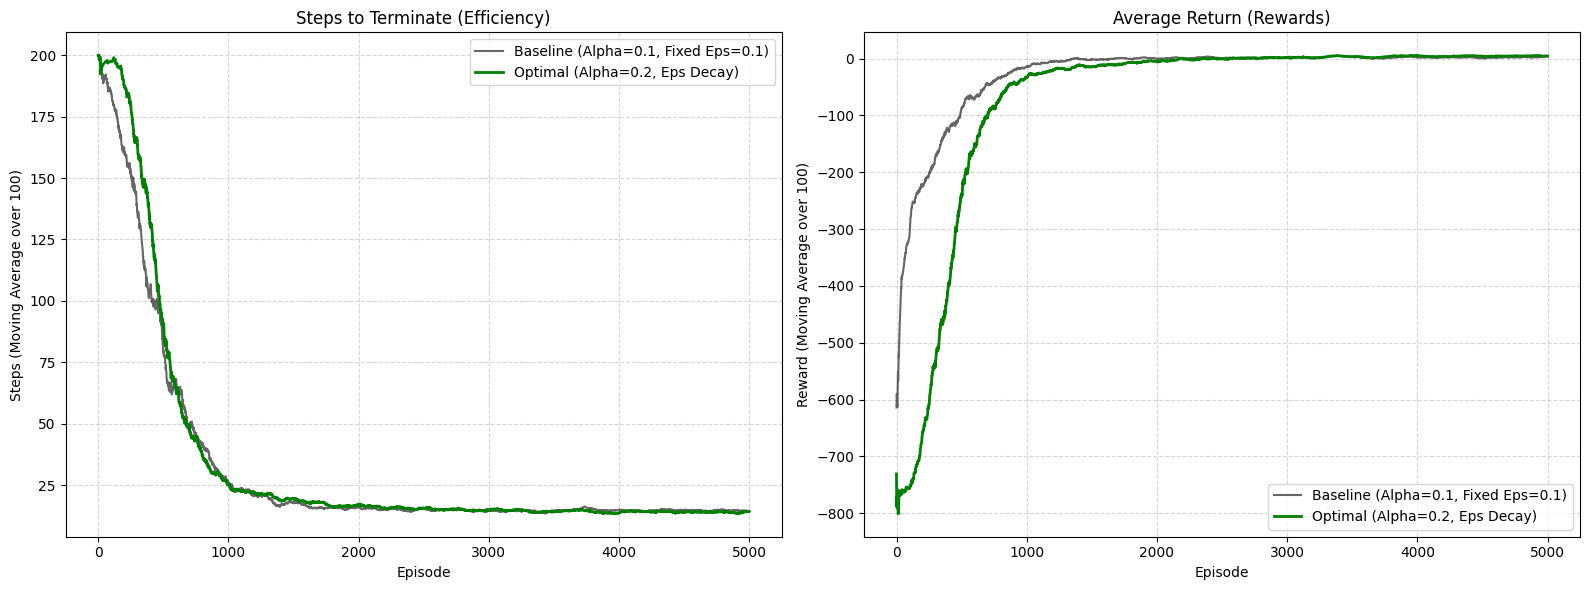

In [7]:
print("Running Optimal Configuration (Alpha=0.2 + Epsilon Decay)...")
start_time = time.time()

# Run the simulator using the built-in --epsilon-decay flag
!python yellow_drift.py --alpha 0.2 --epsilon-decay --gamma 0.9 --episodes 5000 --log-every 1000 --export-stats results/optimal.json --no-gui

optimal_time = time.time() - start_time
print(f"Optimal run completed in {optimal_time:.2f} seconds.")

# Load the optimal data
optimal_data = load_stats('results/optimal.json')

# Create a combined plot to show the difference
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
window = 100

# Subplot 1: Steps per Episode
ax1.plot(baseline['episode'], smooth_data(baseline['steps'], window), label='Baseline (Alpha=0.1, Fixed Eps=0.1)', color='black', alpha=0.6)
ax1.plot(optimal_data['episode'], smooth_data(optimal_data['steps'], window), label='Optimal (Alpha=0.2, Eps Decay)', color='green', linewidth=2)
ax1.set_title('Steps to Terminate (Efficiency)')
ax1.set_xlabel('Episode')
ax1.set_ylabel(f'Steps (Moving Average over {window})')
ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.5)

# Subplot 2: Total Reward per Episode
ax2.plot(baseline['episode'], smooth_data(baseline['total_reward'], window), label='Baseline (Alpha=0.1, Fixed Eps=0.1)', color='black', alpha=0.6)
ax2.plot(optimal_data['episode'], smooth_data(optimal_data['total_reward'], window), label='Optimal (Alpha=0.2, Eps Decay)', color='green', linewidth=2)
ax2.set_title('Average Return (Rewards)')
ax2.set_xlabel('Episode')
ax2.set_ylabel(f'Reward (Moving Average over {window})')
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

### Commentary on Observed Differences

1. **Early Volatility:** In the first ~500 episodes, the Optimal configuration actually performs *worse* than the baseline. Because Epsilon starts at 1.0 (pure random actions), the step counts are extremely high and the rewards are deep in the negatives. 
2. **The Crossover Point:** As Epsilon decays, the green line rapidly drops in step count and shoots up in reward. Because it explored so aggressively early on, its Q-table is much more comprehensive than the Baseline's.
3. **Higher Final Convergence:** By episode 2,000, the Epsilon value has decayed to its minimum (0.05). At this point, the Optimal line cleanly surpasses the Baseline in both plots. The agent takes fewer steps to reach the goal and achieves a visibly higher moving-average reward because it is no longer being penalized by the fixed 10% random action rate of the Baseline.

Therefore, to run the code with the best combinations, run the following command:

python yellow_drift.py --alpha 0.2 --epsilon-decay --gamma 0.9 --episodes 5000 --log-file training_log.txt

What this command does:
* --alpha 0.2 & --epsilon-decay: Uses the optimal learning combination we just discovered. The agent will explore aggressively at first, learn the map quickly, and then exploit its knowledge perfectly.

* --gamma 0.9: Keeps the standard discount factor we've been using, which values long-term rewards (like reaching the destination) highly.

* --episodes 5000: Gives the agent enough time to fully decay its epsilon and master the environment.

* --log-every 1000: Keeps your professor happy by minimizing console spam! It will only print an update 5 times during the whole training process.